In [1]:
from NonlinearController.model_utils import *
from NonlinearController.systems import FullUnbalancedDisc, SinCosUnbalancedDisc, ReversedSinCosUnbalancedDisc
from matplotlib import pyplot as plt
import deepSI
from casadi import *
import torch
import random
import time
from NonlinearController.utils import *

(CVXPY) Aug 08 05:10:49 PM: Encountered unexpected exception importing solver PROXQP:
ImportError('DLL load failed while importing instructionset: The specified module could not be found.')


In [2]:
##################  System  #######################
dt = 0.1
system = FullUnbalancedDisc(dt=dt)
# system = ReversedSinCosUnbalancedDisc(dt=dt, sigma_n=[0.0])

system.reset_state()

##################  MPC variable specification  #######################
Nc=5; nr_sim_steps = 100#int(6e4)

Q = np.array([[1,0],[0,1000]]); R = 0.1

w_min = -5; w_max = 5
# q_min = [-np.pi]; q_max = [np.pi]
q_min = [-100]; q_max = [100]
w0 = 0; q0 = np.array([[0,0]]).T; x0 = np.array([[0,0]]).T

# a = 3.1; reference = np.hstack((np.ones(20)*a,np.ones(20)*-a,np.ones(20)*a/2,np.ones(20)*-a/2,np.ones(40)*0))
reference = np.load("NonlinearController/references/multiSine.npy")

In [3]:
##################  Offline Computation  #######################
# describe physical model
g = 9.80155078791343; J = 0.000244210523960356; Km = 10.5081817407479; l = 0.0410772235841364; M = 0.0761844495320390; tau= 0.397973147009910

nx = 2; x = MX.sym("x",nx,1)
nu = 1; u = MX.sym("u",nu,1)
ny = 2
x_rhs = vertcat(-M*g*l/J*np.sin(x[1])-1/tau*x[0]+Km/tau*u, x[0])
y_rhs = vertcat(x[0],x[1])

f = Function('f', [x, u], [x_rhs])
h = Function('h', [x], [y_rhs])

# define initial predicted states and inputs
X0 = np.tile(x0,Nc+1)
U0 = np.ones((Nc)*nu)[np.newaxis]*w0
Y0 = np.tile(q0,Nc)

# define opti stack
opti  = Opti()

states = opti.variable(nx, Nc+1)
controls = opti.variable(nu, Nc)
outputs = opti.variable(ny, Nc)

x_initial = opti.parameter(nx, 1)
y_ref = opti.parameter(ny, Nc)
u_ref = opti.parameter(nu, Nc)

opti.subject_to(opti.bounded(q_min,outputs,q_max))
opti.subject_to(opti.bounded(w_min,controls,w_max))
opti.subject_to(states[:,0] == x_initial)

opti.set_initial(states, X0)
opti.set_initial(controls, U0)
opti.set_initial(outputs, Y0)

opti.set_value(x_initial,X0[:,0])
# opti.set_value(y_ref, reference[:Nc])

opts = {'print_time' : 0, 'ipopt': {'print_level': 0}}
opti.solver("ipopt",opts)

objective = 0
for i in np.arange(Nc):
    opti.subject_to(states[:,i+1] == my_rk4(states[:,i],controls[:,i],f,dt,1))
    opti.subject_to(outputs[:,i] == h(states[:,i+1]))
    objective = (objective + 
                    mtimes(mtimes((outputs[:,i] - y_ref[:,i]).T,Q),(outputs[:,i] - y_ref[:,i])) +
                    mtimes(mtimes((controls[:,i] - u_ref[:,i]).T,R),(controls[:,i] - u_ref[:,i])))

opti.minimize(objective)

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))
log_w = np.zeros((nu,nr_sim_steps))

components_time = np.zeros((2, nr_sim_steps))

In [4]:
##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    component_start = time.time()
    
    opti.set_value(y_ref, np.vstack((np.zeros(Nc), reference[k:k+Nc])))
    opti.set_value(u_ref, setPointInput(reference[k:k+Nc]))

    components_time[0, k] = components_time[0, k] + time.time() - component_start
    component_start = time.time()

    sol = opti.solve()

    components_time[1, k] = components_time[1, k] + time.time() - component_start
    component_start = time.time()

    U0[0,:] = sol.value(controls)
    X0[:,:] = sol.value(states)
    Y0[:,:] = sol.value(outputs)

    # determine input from optimal velocity input
    u0 = U0[:,0]
    # measure output then apply input
    system.x = system.f(system.x, u0[0])
    q1 = np.array(system.h(system.x, u0[0]))
    # predict state with encoder
    x1 = system.x[np.newaxis].T

    # shift predicted states, input, and output one time step k
    X0[:, :-1] = X0[:, 1:]; X0[:, -1:] = X0[:, -2:-1]; X0[:, :1] = x1
    U0[:, :-1] = U0[:, 1:]; U0[:, -1:] = U0[:, -2:-1]; U0[:, :1] = u0
    Y0[:, :-1] = Y0[:, 1:]; Y0[:, -1:] = Y0[:, -2:-1]; Y0[:, :1] = q1[np.newaxis].T

    opti.set_initial(states, X0)
    opti.set_initial(controls, U0)
    opti.set_initial(outputs, Y0)
    opti.set_value(x_initial,x1)

    # log system signals
    log_q[:,k] = q1
    log_w[:,k] = u0

    components_time[0, k] = components_time[0, k] + time.time() - component_start

    # print progress
    print("Sim step: " + str(k))
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Sim step: 0
Sim step: 1
Sim step: 2
Sim step: 3
Sim step: 4
Sim step: 5
Sim step: 6
Sim step: 7
Sim step: 8
Sim step: 9
Sim step: 10
Sim step: 11
Sim step: 12
Sim step: 13
Sim step: 14
Sim step: 15
Sim step: 16
Sim step: 17
Sim step: 18
Sim step: 19
Sim step: 20
Sim step: 21
Sim step: 22
Sim step: 23
Sim step: 24
Sim step: 25
Sim step: 26
Sim step: 27
Sim step: 28
Sim step: 29
Sim step: 30
Sim step: 31
Sim step: 32
Sim step: 33
Sim step: 34
Sim step: 35
Sim step: 36
Sim step: 37
Sim step: 38
Sim step: 39
Sim step: 40
Sim step: 41
Sim step: 42
Sim step: 43
Sim step: 44
Sim step: 45
Sim step: 46
Sim step: 4

In [5]:
avg_time_step = np.sum(components_time)/nr_sim_steps
avg_time_step*1000

7.883527278900147

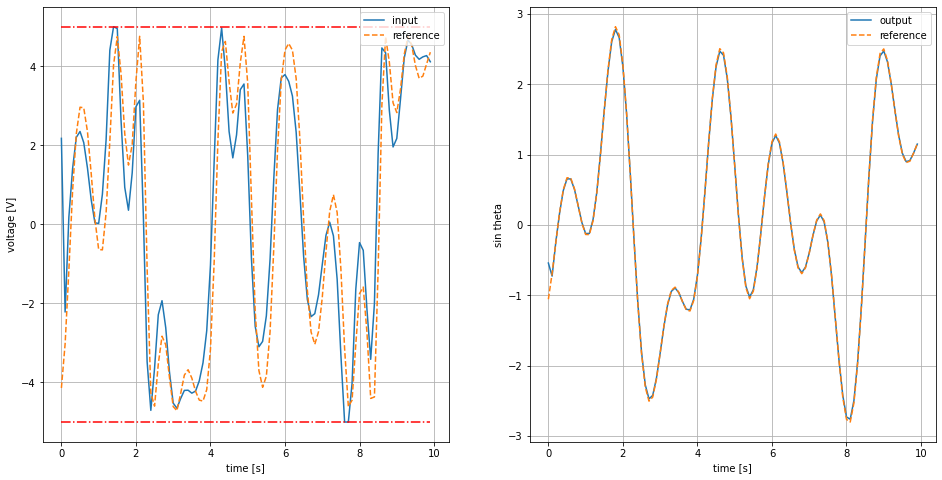

In [6]:
fig1 = plt.figure(figsize=[16, 8])
plt_start = 0; plt_len = 100; plt_end = plt_start + plt_len

plt.subplot(1,2,1)
plt.plot(np.arange(plt_len)*dt, log_w[0,plt_start:plt_end], label='input')
plt.plot(np.arange(plt_len)*dt, setPointInput(reference[plt_start:plt_end]), '--', label='reference')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*w_min, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(np.arange(plt_len)*dt, log_q[1,:plt_len], label='output')
plt.plot(np.arange(plt_len)*dt, reference[:plt_len], '--', label='reference')
# plt.plot(np.arange(plt_len)*dt, log_q[0,:plt_len] - np.sin(reference[:plt_len]), '-', label='error')
# plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_max[0], 'r-.')#, label='max')
# plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_min[0], 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("sin theta")
plt.grid()
plt.legend(loc='upper right')

# plt.subplot(1,3,3)
# plt.plot(np.arange(plt_len)*dt, log_q[1,:plt_len], label='output')
# plt.plot(np.arange(plt_len)*dt, np.cos(reference[:plt_len]), '--', label='reference')
# # plt.plot(np.arange(plt_len)*dt, log_q[1,:plt_len] - np.cos(reference[:plt_len]), '-', label='error')
# plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_max[0], 'r-.')#, label='max')
# plt.plot(np.arange(plt_len)*dt, np.ones(plt_len)*q_min[0], 'r-.')#, label='min')
# plt.xlabel("time [s]")
# plt.ylabel("cos theta")
# plt.grid()
# plt.legend(loc='upper right')

plt.show()

In [7]:
np.save("NonlinearController/experiments/ud_nmpc_sinus_u.npy", log_w)
np.save("NonlinearController/experiments/ud_nmpc_sinus_q.npy", log_q)
nr_sim_steps = log_w.shape[1]; dt=0.1

# np.save("NonlinearController/data/noiseless_smallRef_NMPC_w.npy", log_w)
# np.save("NonlinearController/data/noiseless_smallRef_NMPC_q.npy", log_q)

In [ ]:
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.hist(log_w[0,:], 45)
plt.xlabel("u [V]")
plt.ylabel("count")
plt.subplot(1,3,2)
plt.hist(log_q[0,:], 45)
plt.xlabel("sin theta")
plt.ylabel("count")
plt.subplot(1,3,3)
plt.hist(log_q[1,:], 45)
plt.xlabel("cos theta")
plt.ylabel("count")
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,4))
y = np.arctan2(log_q[0,:], log_q[1,:])
plt.subplot(1,2,1)
plt.plot(np.fft.fftfreq(nr_sim_steps, d=dt), np.log(abs(np.fft.fft(log_w[0,:])))/1)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude dB")
plt.title('input u [V]')
plt.subplot(1,2,2)
plt.plot(np.fft.fftfreq(nr_sim_steps, d=dt), np.log(abs(np.fft.fft(y)))/1)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude dB")
plt.title('output theta')

In [ ]:
plt.plot(y[:200])